In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import hydrobm
import xarray as xr
import matplotlib.pyplot as plt
from hydrobm.calculate import calc_bm

### Inputs

In [2]:
# Define input file paths
performance_metrics= '../../model/model_versions/v_7/v7_1/hds_model/hds_results.csv'

pobs= '../../model/model_versions/v_7/v7_1/hds_model/Pobs.txt'

tobs= '../../model/model_versions/v_7/v7_1/hds_model/Tobs.txt'

qobs= '../../model/model_versions/v_7/v7_1/hds_model/Qobs.txt'

geodata= '../../model/model_versions/v_7/v7_1/hds_model/GeoData.txt'

gauge_info= '../../geospacial/misc/hype_naturalized_flows_summary.csv'

output_dir= './output_plot_test/'

var_to_plot= 'kge_val'

In [3]:
# Define calibration and validation periods
calibration_ranges = [('1980-10-01', '1984-09-30'),
               ('1989-10-01', '1998-09-30'),
               ('2003-10-01', '2007-09-30'),
               ('2012-10-01', '2015-09-30')]

validation_ranges = [('1984-10-01', '1989-09-30'),
               ('1998-10-01', '2003-09-30'),
               ('2007-10-01', '2012-09-30')]

In [4]:
# Specify the benchmarks and metrics to calculate
benchmarks = [
        # Streamflow benchmarks
        "mean_flow",
        "median_flow",
        "annual_mean_flow",
        "annual_median_flow",
        "monthly_mean_flow",
        "monthly_median_flow",
        "daily_mean_flow",
        "daily_median_flow",

        # Long-term rainfall-runoff ratio benchmarks
        "rainfall_runoff_ratio_to_all",
        "rainfall_runoff_ratio_to_annual",
        "rainfall_runoff_ratio_to_monthly",
        "rainfall_runoff_ratio_to_daily",
        "rainfall_runoff_ratio_to_timestep",

         # Short-term rainfall-runoff ratio benchmarks
        "monthly_rainfall_runoff_ratio_to_monthly",
        "monthly_rainfall_runoff_ratio_to_daily",
        "monthly_rainfall_runoff_ratio_to_timestep",

        # Schaefli & Gupta (2007) benchmarks
        "scaled_precipitation_benchmark",  # equivalent to "rainfall_runoff_ratio_to_daily"
        "adjusted_precipitation_benchmark",
        "adjusted_smoothed_precipitation_benchmark",
     ]

metrics = ['nse', 'kge'] # could also use 'mse', 'rmse'

### Analysis

Prepare Data

In [5]:
# Read data
performance_metrics= pd.read_csv(performance_metrics, index_col=0 )
pobs= pd.read_csv(pobs, index_col=0, sep='\t') 
tobs= pd.read_csv(tobs, index_col=0, sep='\t') 
qobs= pd.read_csv(qobs, index_col=0, sep='\t') 
geodata= pd.read_csv(geodata, index_col=0, sep='\t') 
gauge_info= pd.read_csv(gauge_info, index_col=0)

In [6]:
# convert index to datetime
pobs.index = pd.to_datetime(pobs.index)
tobs.index = pd.to_datetime(tobs.index)
qobs.index = pd.to_datetime(qobs.index)

# Set index to int
geodata.index = geodata.index.astype(int)

# Convert column headers to integers
pobs.columns = pobs.columns.astype(int)
tobs.columns = tobs.columns.astype(int)
qobs.columns = qobs.columns.astype(int)

In [7]:
# Extract performance metrics index
subbasin_ids= performance_metrics.index

In [8]:
# Convert the ranges to Pandas Timestamps
calibration_ranges = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in calibration_ranges]
validation_ranges = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in validation_ranges]

In [9]:
riv_graph = nx.DiGraph()

# Add edges from DataFrame
for idx, row in geodata.iterrows():
    if row['maindown'] != '0':  # Skip if maindown is '0'
        riv_graph.add_edge(idx, row['maindown'])


In [10]:
# replace missing values with nan in streamflow
qobs.replace(-9999, np.nan, inplace=True)

In [11]:
# Convert streamflow from m3/s to m3
qobs= qobs * 86400 # s / day

In [12]:
# Set area column to numeric
geodata['area'] = pd.to_numeric(geodata['area'])

# Create dictionary with subbasin ID and area
area_dict = geodata['area'].to_dict()

In [13]:
# Convert pobs from mm to m3
pobs= pobs / 1000 # mm to m

# Multiply each column in pobs by the corresponding area value in area_dict
for col in pobs.columns:
    if col in area_dict:
        pobs[col] *= area_dict[col]

### Calculate Benchmarks

In [14]:
# Select the four best benchmarks for plotting
def top_n_indices_and_values(values_list, n=4):
    arr = np.array(values_list) # numpy array
    nan_idx = np.where(np.isnan(arr)) # find nan values
    arr_sort = arr.argsort() # sort the full array, nans go at the end
    arr_sort = arr_sort[~np.isin(arr_sort, nan_idx)] # remove nans
    indices = arr_sort[-n:] # get the top n indices
    values = arr[indices] # get the values
    return indices.tolist(), values.tolist()

In [15]:
# Define an empty list to store the messages
worse_than_benchmark_list = []

# Initialize an empty DataFrame to store top benchmarks and their KGE values
kge_cal= pd.DataFrame()
kge_val= pd.DataFrame()
nse_cal= pd.DataFrame()
nse_val= pd.DataFrame()

In [16]:
# Iterate over each subbasin in performance_metrics
for subbasin in performance_metrics.index: #for subbasin in performance_metrics.index

    print(f'Analyzing Subbasin {subbasin}')
    
    # Find upstream segments for the given subbasin
    upstream_segments = list(nx.ancestors(riv_graph, subbasin))
    
    # Add the target segment to the upstream segments
    upstream_segments.append(subbasin)

    # Sum upstream precipitation
    precipitation_sum = pd.DataFrame(pobs[upstream_segments].sum(axis=1), columns=['precipitation'])

    # Create hydrobm input dataframe
    bm_input = pd.DataFrame({
        'streamflow': qobs[subbasin],  # Streamflow for the given subbasin
        'precipitation': precipitation_sum['precipitation'],  # Sum of upstream precipitation
        'temperature': tobs[subbasin]
    })

    # Create the cal_mask column
    bm_input['cal_mask'] = bm_input.index.to_series().apply(
        lambda x: any(pd.to_datetime(start) <= x <= pd.to_datetime(end) for start, end in calibration_ranges)
    )

    # Create the val_mask column
    bm_input['val_mask'] = bm_input.index.to_series().apply(
        lambda x: any(pd.to_datetime(start) <= x <= pd.to_datetime(end) for start, end in validation_ranges)
    )

    # Calculate the benchmarks and scores
    benchmark_flows, scores = calc_bm(
        bm_input,

        # Time period selection
        bm_input['cal_mask'],
        val_mask=bm_input['val_mask'],

        # Variable names in 'data'
        precipitation="precipitation",
        streamflow="streamflow",

        # Benchmark choices
        benchmarks=benchmarks,
        metrics=metrics,
        optimization_method="brute_force",

        # Snow model inputs
        calc_snowmelt=True,
        temperature="temperature",
        snowmelt_threshold=0.0,
        snowmelt_rate=3.0,
    )

    # Get top 4 KGE scores and corresponding benchmarks
    idx, vals = top_n_indices_and_values(scores[var_to_plot], 4)
    top_benchmarks = [scores['benchmarks'][id] for id in idx]
    top_kge_vals = [scores[var_to_plot][id] for id in idx]

    # Add model result (from 'kge_val' in df) for the current subbasin
    model_kge_cal = performance_metrics.loc[subbasin, 'Cal KGE']
    model_kge_val = performance_metrics.loc[subbasin, 'Val KGE']
    model_nse_cal = performance_metrics.loc[subbasin, 'Cal NSE']
    model_nse_val = performance_metrics.loc[subbasin, 'Val NSE']
    
    # Extract all benchmark scores for the subbasin
    all_benchmarks = scores['benchmarks']
    bench_kge_cal = scores['kge_cal']
    bench_kge_val = scores['kge_val']
    bench_nse_cal = scores['nse_cal']
    bench_nse_val = scores['nse_val']

    # Store the benchmarks and KGE values in a DataFrame, with subbasin as the row
    kge_cal_row = pd.DataFrame([list(bench_kge_cal) + [model_kge_cal]], 
                                 index=[subbasin], 
                                 columns=list(all_benchmarks) + ['model_results'])
        # Store the benchmarks and KGE values in a DataFrame, with subbasin as the row
    kge_val_row = pd.DataFrame([list(bench_kge_val) + [model_kge_val]], 
                                 index=[subbasin], 
                                 columns=list(all_benchmarks) + ['model_results'])
        # Store the benchmarks and KGE values in a DataFrame, with subbasin as the row
    nse_cal_row = pd.DataFrame([list(bench_nse_cal) + [model_nse_cal]], 
                                 index=[subbasin], 
                                 columns=list(all_benchmarks) + ['model_results'])
        # Store the benchmarks and KGE values in a DataFrame, with subbasin as the row
    nse_val_row = pd.DataFrame([list(bench_nse_val) + [model_nse_val]], 
                                 index=[subbasin], 
                                 columns=list(all_benchmarks) + ['model_results'])
    
    # Concatenate the current row to the top_benchmark_df (append all benchmarks)
    kge_cal = pd.concat([kge_cal, kge_cal_row], axis=0)
    kge_val = pd.concat([kge_val, kge_val_row], axis=0)
    nse_cal = pd.concat([nse_cal, nse_cal_row], axis=0)
    nse_val = pd.concat([nse_val, nse_val_row], axis=0)

    # Reformat the scores for cleaner saving 
    col_names = scores.pop("benchmarks", None)
    df = pd.DataFrame(scores, index=col_names)
    df = df.T

        # Add the model_results column with performance metrics for the subbasin
    df['model_results'] = None  # Initialize the column
    df.loc['kge_cal', 'model_results'] = performance_metrics.loc[subbasin, 'Cal KGE']
    df.loc['kge_val', 'model_results'] = performance_metrics.loc[subbasin, 'Val KGE']
    df.loc['nse_cal', 'model_results'] = performance_metrics.loc[subbasin, 'Cal NSE']
    df.loc['nse_val', 'model_results'] = performance_metrics.loc[subbasin, 'Val NSE']

    # Save the DataFrame to CSV in the output directory
    df_filepath = os.path.join(output_dir, f"subbasin_{subbasin}_scores.csv")
    df.to_csv(df_filepath)
    
        # Plot streamflow along with the four best benchmarks
    fig, ax = plt.subplots(4, 1, figsize=(14, 14))
    for i, (bm, kge) in enumerate(zip(top_benchmarks, top_kge_vals)):
        bm_input['streamflow'].plot(ax=ax[i], linewidth=2, label='streamflow')
        benchmark_flows[f'bm_{bm}'].plot(ax=ax[i], label=bm)
        ax[i].legend(loc='upper left')
        ax[i].set_title(f"{subbasin}_{bm}_(BM Val KGE: {kge:.2f}, Model Val KGE: {df.loc[var_to_plot, 'model_results']:.2f})")
        ax[i].set_xlabel('')  # Drops 'Date'

    plt.tight_layout()

    # Save the figure to the output directory
    fig_filepath = os.path.join(output_dir, f"subbasin_{subbasin}_benchmark_plot.png")
    fig.savefig(fig_filepath)
    plt.close(fig)  # Close the figure after saving to free memory
    
    # Iterate through each row in df
    for idx, row in df.iterrows():
        # Loop through all columns except 'model_results'
        for col in df.columns:
            if col != 'model_results' and row['model_results'] < row[col]:
                message = f"{subbasin}_{idx} is worse than benchmark in {col}"
              #  print(message)  # Print the message
                worse_than_benchmark_list.append(message)  # Append the message to the list


Analyzing Subbasin 58643
Analyzing Subbasin 58425
Analyzing Subbasin 58418
Analyzing Subbasin 58408
Analyzing Subbasin 58398
Analyzing Subbasin 58363
Analyzing Subbasin 58356
Analyzing Subbasin 58346
Analyzing Subbasin 58328
Analyzing Subbasin 58308
Analyzing Subbasin 58290
Analyzing Subbasin 58223
Analyzing Subbasin 58213
Analyzing Subbasin 58208


In [17]:
index_to_gauge_id = gauge_info['Gauge ID'].to_dict()

In [18]:
# Update the index of kge_cal
kge_cal.index = kge_cal.index.map(index_to_gauge_id)
kge_val.index = kge_val.index.map(index_to_gauge_id)
nse_cal.index = nse_cal.index.map(index_to_gauge_id)
nse_val.index = nse_val.index.map(index_to_gauge_id)

In [19]:
kge_cal.index = kge_cal.index.astype(str)
kge_val.index = kge_val.index.astype(str)
nse_cal.index = nse_cal.index.astype(str)
nse_val.index = nse_val.index.astype(str)

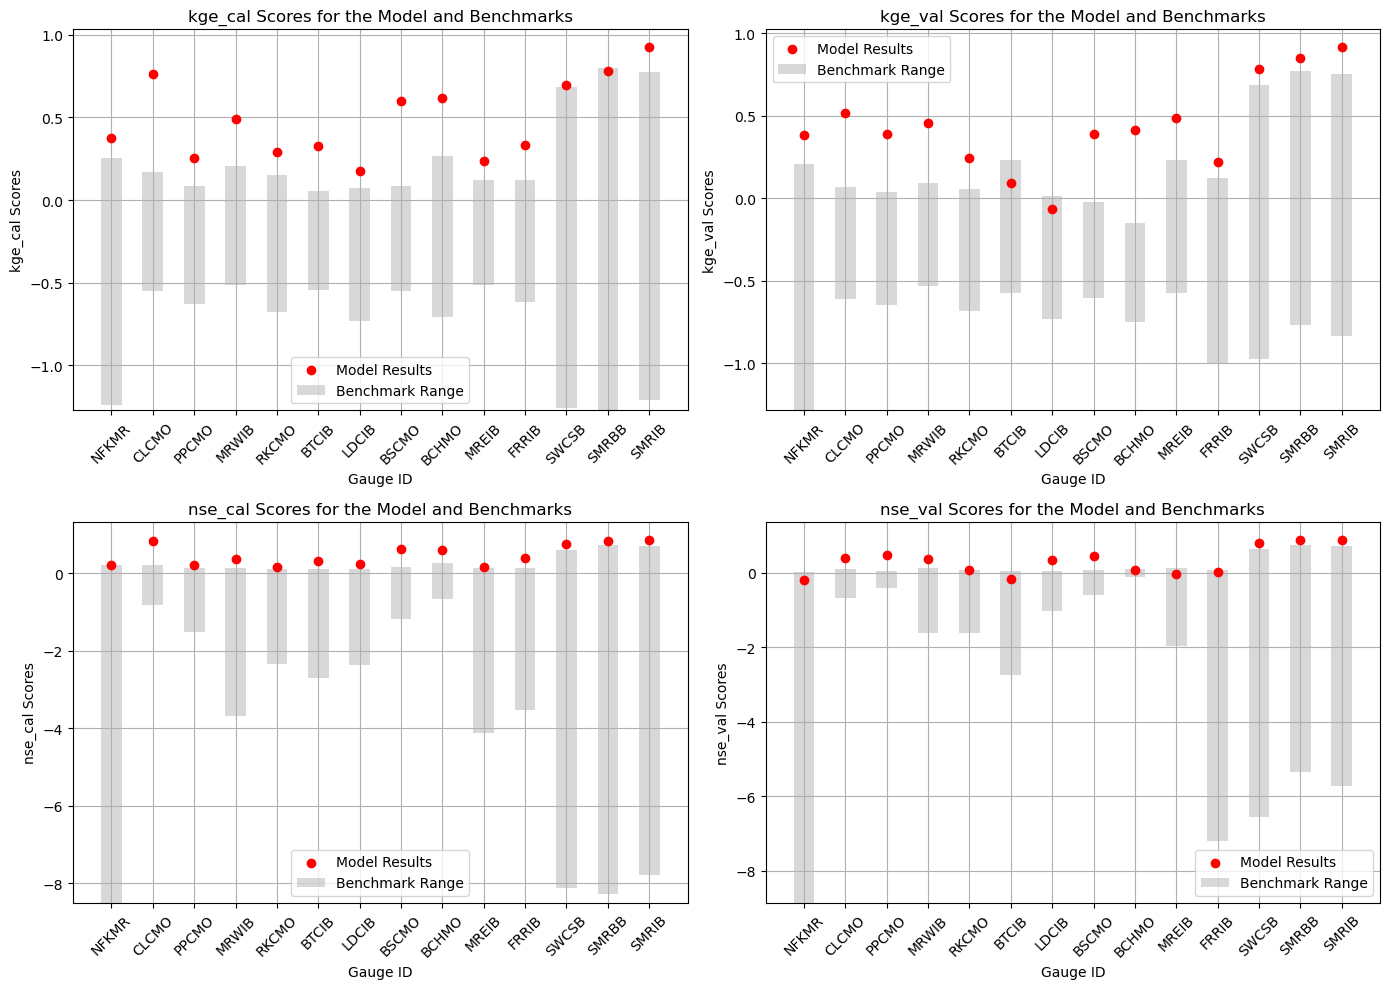

In [21]:
# Set the variable to plot based on your naming convention
variables = {
    "kge_cal": kge_cal,
    "kge_val": kge_val,
    "nse_cal": nse_cal,
    "nse_val": nse_val,
}

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate through the metrics and their corresponding axes
for ax, (var_name, df) in zip(axs, variables.items()):
    # Extract the 'model_results' column separately

    model_results = df['model_results']
    other_benchmarks = df.drop(columns=['model_results'])

    # Find the min and max across all benchmark columns (except model_results) for each subbasin
    benchmark_min = other_benchmarks.min(axis=1)
    benchmark_max = other_benchmarks.max(axis=1)

    # Scatter plot for 'model_results' as separate dots
    ax.scatter(df.index, model_results, color='red', label='Model Results', zorder=5)

    # Create vertical bars for the benchmark range (min to max)
    ax.bar(
        df.index,
        benchmark_max - benchmark_min,  # Height of the bars (difference between max and min)
        bottom=benchmark_min,           # Starting point of the bars (min value)
        color='gray',
        alpha=0.3,
        label='Benchmark Range',
        width=0.5                        # Adjust bar width as needed
    )

    # Add labels and title
    ax.set_xlabel('Gauge ID')
    ax.set_ylabel(f'{var_name} Scores')
    ax.set_title(f'{var_name} Scores for the Model and Benchmarks')

    # Add a legend
    ax.legend()

    # Display the grid
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Adjust layout
plt.tight_layout()

# Save the figure as PNG to the output directory
fig_filepath = os.path.join(output_dir, f"benchmark_scores_plot.png")
plt.savefig(fig_filepath)

# Show the plot
plt.show()